# Modeling

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('data/combine_data.csv')
df.index = pd.to_datetime(df['Date'])
df.sort_index(inplace=True)
df.drop(columns='Date',inplace=True)

In [3]:
# Scale the data to range of 0 and 1 for input in LSTM network
scaler = MinMaxScaler(feature_range=(0,1))
df_sc = scaler.fit_transform(df)

# Prepare and reshape the data for LSTM 
X = []
y = []
n_future = 14
n_past = 60

for i in range(n_past,len(df_sc)-n_future):
    X.append(df_sc[i-n_past:i,0:df_sc.shape[1]])
    y.append(df_sc[i+1:i+n_future+1,0])
    
X,y = np.array(X),np.array(y)
print('X shape: ',X.shape)
print('y shape: ',y.shape)


X shape:  (1533, 60, 10)
y shape:  (1533, 14)


In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,shuffle=False)

In [5]:
print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)


X_train shape:  (1379, 60, 10)
y_train shape:  (1379, 14)
X_test shape:  (154, 60, 10)
y_test shape:  (154, 14)


In [6]:
model = Sequential()
model.add(LSTM(128,activation = 'tanh',input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64,activation = 'tanh',return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(30,activation = 'tanh'))

model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           71168     
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 30)                1950      
_________________________________________________________________
dense_1 (Dense)              (None, 14)                434       
Total params: 122,960
Trainable params: 122,960
Non-trainable params: 0
__________________________________________________

In [7]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10, restore_best_weights=False)

history = model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=256,verbose=0,callbacks=[es])

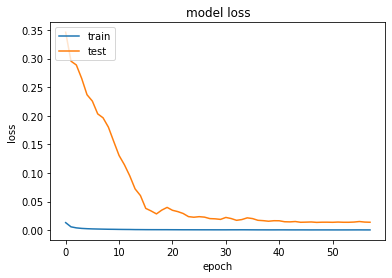

The final val loss is:  0.013585258275270462


In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print('The final val loss is: ',history.history['val_loss'][-11])

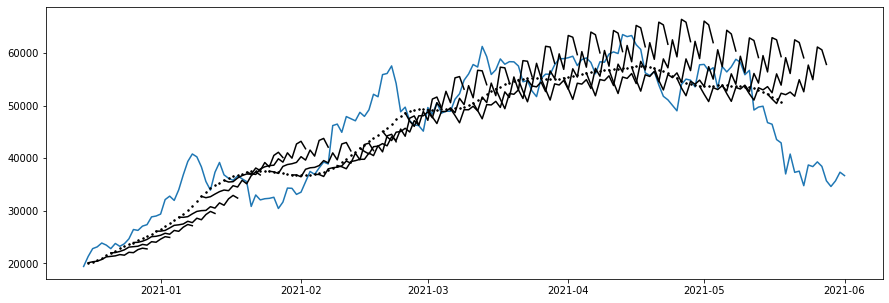

In [20]:
df_forecast = df[['BTC_price']].copy()
forecast = model.predict(X_test)
plt.figure(figsize=(15,5));
plt.plot(df_forecast.index[-forecast.shape[0]-forecast.shape[1]-1:],df_forecast['BTC_price'][-forecast.shape[0]-forecast.shape[1]-1:],label='Truth');
for i in range(forecast.shape[0]):
    forecast[i] = scaler.inverse_transform(np.repeat(forecast[i].reshape(-1,1),df_sc.shape[1],axis=-1))[:,0]
    plt.plot(df_forecast.index[-forecast.shape[0]+i-forecast.shape[1]:-forecast.shape[0]+i-forecast.shape[1]+1],forecast[i][0],'k.',markersize=3);
    if i % 5==0:
        plt.plot(df_forecast.index[-forecast.shape[0]+i-forecast.shape[1]:-forecast.shape[0]+i],forecast[i],'k-',markersize=1);

# Model without the features

In [10]:
df_no_feat = df[['BTC_price']].copy()

In [11]:
# Scale the data to range of 0 and 1 for input in LSTM network
scaler_2 = MinMaxScaler(feature_range=(0,1))
df_no_feat_sc = scaler_2.fit_transform(df_no_feat)

# Prepare and reshape the data for LSTM 
X2 = []
y2 = []

for i in range(n_past,len(df_sc)-n_future):
    X2.append(df_no_feat_sc[i-n_past:i,0:df_no_feat_sc.shape[1]])
    y2.append(df_no_feat_sc[i+1:i+n_future+1,0])
    
X2,y2 = np.array(X2),np.array(y2)
print('X shape: ',X2.shape)
print('y shape: ',y2.shape)


X shape:  (1533, 60, 1)
y shape:  (1533, 14)


In [12]:
X_train_2,X_test_2,y_train_2,y_test_2 = train_test_split(X2,y2,test_size=0.1,shuffle=False)

In [13]:
print('X_train shape: ',X_train_2.shape)
print('y_train shape: ',X_test_2.shape)
print('X_test shape: ',y_train_2.shape)
print('y_test shape: ',y_test_2.shape)

X_train shape:  (1379, 60, 1)
y_train shape:  (154, 60, 1)
X_test shape:  (1379, 14)
y_test shape:  (154, 14)


In [14]:
model2 = Sequential()
model2.add(LSTM(128,activation = 'tanh',input_shape=(X_train_2.shape[1],X_train_2.shape[2]),return_sequences=True))
model2.add(Dropout(0.3))
model2.add(LSTM(64,activation = 'tanh',return_sequences=False))
model2.add(Dropout(0.3))
model2.add(Dense(30,activation = 'tanh'))
model2.add(Dense(y_train_2.shape[1]))

model2.compile(optimizer='adam',loss='mse')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 128)           66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1950      
_________________________________________________________________
dense_3 (Dense)              (None, 14)                434       
Total params: 118,352
Trainable params: 118,352
Non-trainable params: 0
________________________________________________

In [15]:
history_2 = model2.fit(X_train_2,y_train_2,epochs=100,validation_data=(X_test_2,y_test_2),batch_size=256,verbose=0,callbacks=[es])

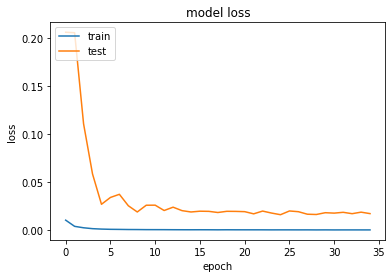

The final val loss is:  0.01631840132176876


In [16]:
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print('The final val loss is: ',history_2.history['val_loss'][-11])

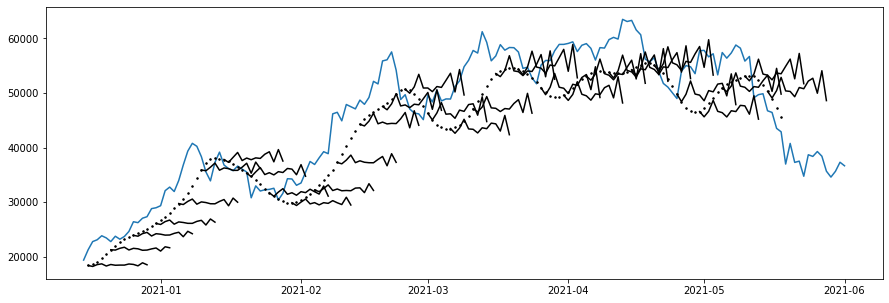

In [17]:
forecast_2 = model2.predict(X_test_2)
plt.figure(figsize=(15,5));
plt.plot(df_forecast.index[-forecast_2.shape[0]-forecast_2.shape[1]-1:],df_forecast['BTC_price'][-forecast_2.shape[0]-forecast_2.shape[1]-1:],label='Truth');
for i in range(forecast_2.shape[0]):
    forecast_2[i] = scaler.inverse_transform(np.repeat(forecast_2[i].reshape(-1,1),df_sc.shape[1],axis=-1))[:,0]
    plt.plot(df_forecast.index[-forecast_2.shape[0]+i-forecast_2.shape[1]:-forecast_2.shape[0]+i-forecast_2.shape[1]+1],forecast_2[i][0],'k.',markersize=3);
    if i % 5==0:
        plt.plot(df_forecast.index[-forecast_2.shape[0]+i-forecast_2.shape[1]:-forecast_2.shape[0]+i],forecast_2[i],'k-',markersize=1);

### The graph below is misleading, the model only predict one day using the previous 50 days, which make it looks like it's very accurate and usable.

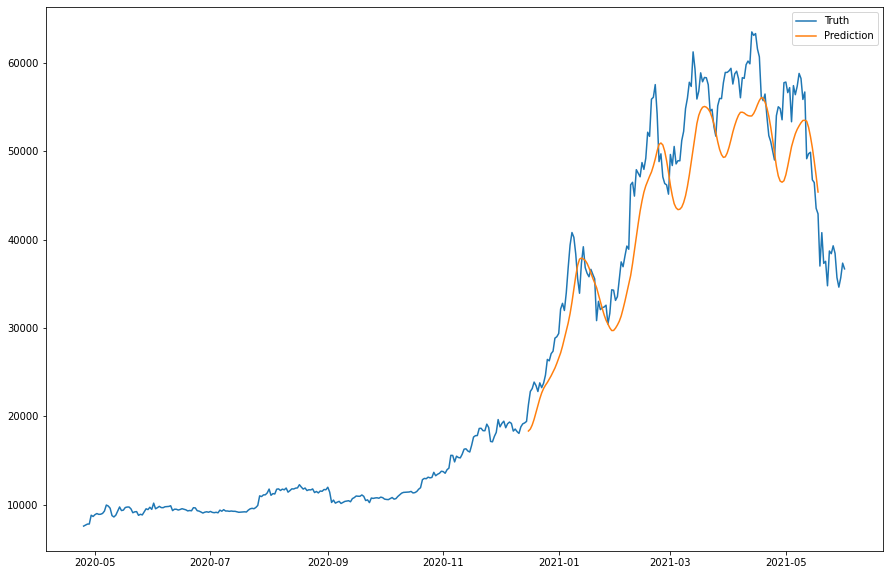

In [26]:
forecast_2 = model2.predict(X_test_2)
forecast_2 = scaler_2.inverse_transform(forecast_2[:,4].reshape(-1,1))[:,0]

# add prediction to dataframe
df_forecast_2 = df[['BTC_price']].copy()
df_forecast_2['forecast'] = np.nan

df_forecast_2['forecast'].iloc[-forecast_2.shape[0]-n_future:-n_future] = forecast_2

plt.figure(figsize=(15,10));
plt.plot(df_forecast_2.index[-400:],df_forecast_2['BTC_price'][-400:],label='Truth');
plt.plot(df_forecast_2.index,df_forecast_2['forecast'],label='Prediction');
plt.legend();